### Preprocessing Function

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix


In [90]:
adult_train = 'adult/adult.data'
adult_test = 'adult/adult.test'
churn ='churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'
credit_card = 'creditcard/creditcard.csv'

In [91]:
def preprocess(choice):
    if choice == 'adult':
        df_train = pd.read_csv(adult_train, header=None)
        df_test = pd.read_csv(adult_test, header=None, skiprows=1) # skip the first row

        df_train = df_train.replace(' ?', np.nan)
        df_test = df_test.replace(' ?', np.nan)

        # drop NaN
        # df = df.dropna()
        # df_test = df_test.dropna()

        for col in df_train.columns:
            if df_train[col].dtype == 'object':
                df_train[col] = df_train[col].fillna(df_train[col].mode()[0])
            else:
                df_train[col] = df_train[col].fillna(df_train[col].mean())

        for col in df_test.columns:
            if df_test[col].dtype == 'object':
                df_test[col] = df_test[col].fillna(df_test[col].mode()[0])
            else:
                df_test[col] = df_test[col].fillna(df_test[col].mean())

        df_train[14] = df_train[14].apply(lambda x: 1 if x == ' >50K' else 0)
        df_test[14] = df_test[14].apply(lambda x: 1 if x == ' >50K.' else 0)
        
        X_train = df_train.iloc[:, :-1]
        y_train = df_train.iloc[:, -1]
        X_test = df_test.iloc[:, :-1]
        y_test = df_test.iloc[:, -1]

            
        for col in X_train.columns:
            if X_train[col].dtype == 'object' and len(X_train[col].unique()) == 2:
                le = LabelEncoder()
                X_train[col] = le.fit_transform(X_train[col])
            
            elif X_train[col].dtype == 'object':
                X_train = pd.get_dummies(X_train, columns=[col], drop_first=True)

        for col in X_test.columns:
            if X_test[col].dtype == 'object' and len(X_test[col].unique()) == 2:
                le = LabelEncoder()
                X_test[col] = le.fit_transform(X_test[col])
            
            elif X_test[col].dtype == 'object':
                X_test = pd.get_dummies(X_test, columns=[col], drop_first=True)

        #add missing columns to test set
        missing_cols = set(X_train.columns) - set(X_test.columns)
        for col in missing_cols:
            X_test[col] = 0
        X_test = X_test[X_train.columns]

        for col in X_train.columns.values:
            scalar = StandardScaler()
            X_train[col] = scalar.fit_transform(X_train[col].values.reshape(-1, 1))
            X_test[col] = scalar.transform(X_test[col].values.reshape(-1, 1))

        # X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        return X_train, X_test, X_val, y_train, y_test, y_val

    elif choice == 'credit_card':
        df = pd.read_csv(credit_card)
        df = df.drop('Time', axis=1)
        #randomly selected 20000 negative samples + all positive samples
        df = pd.concat([df[df['Class'] == 0].sample(20000, random_state=42), df[df['Class'] == 1]])
        # shuffle
        df = df.sample(frac=1, random_state=42)

        # split X and y
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]

        for col in X.columns:
            if len(X[col].unique()) > 2 and X[col].dtype == 'object':

                X = pd.get_dummies(X, columns=[col], drop_first=True)
            elif  X[col].dtype == 'object':
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col])

        for col in X.columns:
            if len(X[col].unique()) > 2:
                scaler = StandardScaler()  
                X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        # X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        return X_train, X_test, X_val, y_train, y_test, y_val
    
    elif choice == 'churn':
        df = pd.read_csv(churn)
        df = df.drop('customerID', axis=1)

        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

        for col in df.columns:
            if df[col].dtype == 'object':
                df[col] = df[col].fillna(df[col].mode()[0])  # Fill NaN for categorical columns
            else:
                df[col] = df[col].fillna(df[col].mean())  # Fill NaN for numeric columns

        df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]

        for col in X.columns:
            if len(X[col].unique()) > 2 and X[col].dtype == 'object':
                X = pd.get_dummies(X, columns=[col], drop_first=True)
            elif X[col].dtype == 'object':
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col])

        for col in X.columns:
            if len(X[col].unique()) > 2:
                scaler = StandardScaler()  
                X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))

        # change boolean columns to binary
        for col in X.columns:
            if X[col].dtype == 'bool':
                X[col] = X[col].apply(lambda x: 1 if x == True else 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        #X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        return X_train, X_test, X_val, y_train, y_test, y_val

### K-best Features

In [92]:
def k_best_feature(X_train, y_train, X_val, X_test, top_k, choice):
    if choice == 'information_gain':
        # Calculate the mutual information
        mi_scores = mutual_info_classif(X_train, y_train)
        top_features_idx = np.argsort(mi_scores)[::-1][:top_k]  # Indices of top k features

        # Use .iloc to index columns for DataFrames
        X_train = X_train.iloc[:, top_features_idx]
        X_val = X_val.iloc[:, top_features_idx]
        X_test = X_test.iloc[:, top_features_idx]

        return X_train, X_val, X_test

    elif choice == 'correlation':
        # Calculate correlation for each feature
        correlation = X_train.corrwith(pd.Series(y_train))
        
        # Get indices of the top k features based on absolute correlation
        top_features_idx = correlation.abs().nlargest(top_k).index
        
        # Use .loc to select columns by column names (since index contains column names)
        X_train = X_train.loc[:, top_features_idx]
        X_val = X_val.loc[:, top_features_idx]
        X_test = X_test.loc[:, top_features_idx]

        return X_train, X_val, X_test


### Logistic Regression

In [93]:
class LogisticRegression:
    def __init__(self,learning_rate=0.01, max_epoch=1000):
        self.learning_rate = learning_rate
        self.max_epoch = max_epoch
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        z = np.array(z)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        # initialize weights and bias
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        for epoch in range(self.max_epoch):
            # forward pass
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(z)

            # loss
            # loss = self.loss(y, y_pred)

            # gradient
            dw = np.dot(X.T, (y_pred - y)) / X.shape[0]
            db = np.mean(y_pred - y)

            # update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db


    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        return y_pred
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)
        return y_pred

    def loss(self, y, y_pred):
        y_pred= np.where(y_pred == 0, 1e-15, y_pred)
        y_pred= np.where(y_pred == 1, 1-1e-15, y_pred)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    # return Accuracy Sensitivity Specificity Precision F1-score AUCROC AUPRC
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y_prob = self.sigmoid(np.dot(X, self.weights) + self.bias)

        TP = np.sum((y == 1) & (y_pred == 1))
        TN = np.sum((y == 0) & (y_pred == 0))
        FP = np.sum((y == 0) & (y_pred == 1))
        FN = np.sum((y == 1) & (y_pred == 0))

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        precision = TP / (TP + FP)
        f1_score = 2 * precision * sensitivity / (precision + sensitivity)
        auroc = roc_auc_score(y, y_prob)  # Probabilities for AUROC
        auprc = average_precision_score(y, y_prob)
        
        return accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc

### Bagging

In [94]:
class Bagging:
    def __init__(self, base_model, n_estimators=9, random_seed=42):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.models = []
        self.random_seed = random_seed
        np.random.seed(self.random_seed)

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        # Generate random indices with replacement
        indices = np.random.choice(n_samples, n_samples, replace=True)
        
        # Check if X is a DataFrame, use .iloc for pandas DataFrame
        if isinstance(X, pd.DataFrame):
            return X.iloc[indices], y.iloc[indices]
        else:  # If X is a NumPy array
            return X[indices], y[indices]

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            model = self.base_model()
            X_sample, y_sample = self.bootstrap_sample(X, y)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def get_models(self):
        return self.models
    
    # evaluate the model. average the accuracy, sensitivity, specificity, precision, f1_score 
    def evaluate(self, X, y):
        accuracies = []
        sensitivities = []
        specificities = []
        precisions = []
        f1_scores = []
        aurocs = []
        auprcs = []

        for model in self.models:
            acc, sen, spe, pre, f1, auroc, auprc = model.evaluate(X, y)
            accuracies.append(acc)
            sensitivities.append(sen)
            specificities.append(spe)
            precisions.append(pre)
            f1_scores.append(f1)
            aurocs.append(auroc)
            auprcs.append(auprc)

        # Compute mean and standard deviation
        accuracy_mean, accuracy_std = np.mean(accuracies), np.std(accuracies)
        sensitivity_mean, sensitivity_std = np.mean(sensitivities), np.std(sensitivities)
        specificity_mean, specificity_std = np.mean(specificities), np.std(specificities)
        precision_mean, precision_std = np.mean(precisions), np.std(precisions)
        f1_mean, f1_std = np.mean(f1_scores), np.std(f1_scores)
        auroc_mean, auroc_std = np.mean(aurocs), np.std(aurocs)
        auprc_mean, auprc_std = np.mean(auprcs), np.std(auprcs)

        return (accuracy_mean, accuracy_std, 
                sensitivity_mean, sensitivity_std, 
                specificity_mean, specificity_std, 
                precision_mean, precision_std, 
                f1_mean, f1_std, auroc_mean, auroc_std, auprc_mean, auprc_std)


### Stacking

In [95]:
class Stacking:
    def __init__(self, base_model, meta_model, n_estimators=9,models=[],random_seed=42):
        self.base_model = base_model
        self.meta_model = meta_model()
        self.models = models
        self.n_estimators = n_estimators
        self.is_trained = True if len(models) > 0 else False
        self.random_seed = random_seed
        np.random.seed(self.random_seed)

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)

        if isinstance(X, pd.DataFrame):
            return X.iloc[indices], y.iloc[indices]
        else:  
            return X[indices], y[indices]

    def fit(self, X_train, y_train, X_val, y_val):
        # Train base models
        base_train_preds = np.zeros((X_val.shape[0], self.n_estimators))
        for i in range(self.n_estimators):
            
            if self.is_trained:
                model = self.models[i]
            else:
                model = self.base_model()
                X_sample, y_sample = self.bootstrap_sample(X_train, y_train)
                model.fit(X_sample, y_sample)
                self.models.append(model)

            base_train_preds[:, i] = model.predict(X_val)

        # Augment base model predictions with original validation set features
        X_meta_train = np.hstack((X_val, base_train_preds))

        # Train the meta-model
        self.meta_model.fit(X_meta_train, y_val)

    def predict(self, X_test):
        # Generate predictions from base models
        base_test_preds = np.zeros((X_test.shape[0], self.n_estimators))
        for i, model in enumerate(self.models):
            base_test_preds[:, i] = model.predict(X_test)

        # Augment base model predictions with original test set features
        X_meta_test = np.hstack((X_test, base_test_preds))

        # Meta model prediction
        return self.meta_model.predict(X_meta_test)
    
    def predict_proba(self, X_test):
        # Generate predictions from base models
        base_test_preds = np.zeros((X_test.shape[0], self.n_estimators))
        for i, model in enumerate(self.models):
            base_test_preds[:, i] = model.predict(X_test)

        # Augment base model predictions with original test set features
        X_meta_test = np.hstack((X_test, base_test_preds))

        # Meta model prediction
        return self.meta_model.predict_proba(X_meta_test)
    
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y_prob = self.predict_proba(X)
        TP = np.sum((y == 1) & (y_pred == 1))
        TN = np.sum((y == 0) & (y_pred == 0))
        FP = np.sum((y == 0) & (y_pred == 1))
        FN = np.sum((y == 1) & (y_pred == 0))

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        precision = TP / (TP + FP)
        f1_score = 2 * precision * sensitivity / (precision + sensitivity)
        auroc = roc_auc_score(y, y_prob)
        auprc = average_precision_score(y, y_prob)
        
        return accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc

    

### Voting

In [96]:
class VotingClassifier:
    def __init__(self, base_model, n_estimators=9,models=[],random_seed=42):
        self.base_model = base_model
        self.models = models
        self.n_estimators = n_estimators
        self.is_trained = True if len(models) > 0 else False
        self.random_seed = random_seed
        np.random.seed(self.random_seed)

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)

        if isinstance(X, pd.DataFrame):
            return X.iloc[indices], y.iloc[indices]
        else:  
            return X[indices], y[indices]
        
    def fit(self, X_train, y_train):
        for i in range(self.n_estimators):
            if self.is_trained:
                model = self.models[i]
            else:
                model = self.base_model()
                X_sample, y_sample = self.bootstrap_sample(X_train, y_train)
                model.fit(X_sample, y_sample)
                self.models.append(model)
            
    def predict(self, X):
        # Collect predictions from all models
        predictions = np.array([model.predict(X) for model in self.models])

        # Take the majority vote
        y_pred = np.mean(predictions, axis=0)
        y_pred = np.where(y_pred > 0.5, 1, 0)

        return y_pred
    
    def predict_proba(self, X):
        # Collect predictions from all models
        predictions = np.array([model.predict_proba(X) for model in self.models])

        # Take the majority vote
        y_prob = np.mean(predictions, axis=0)

        return y_prob
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y_prob = self.predict_proba(X)
        TP = np.sum((y == 1) & (y_pred == 1))
        TN = np.sum((y == 0) & (y_pred == 0))
        FP = np.sum((y == 0) & (y_pred == 1))
        FN = np.sum((y == 1) & (y_pred == 0))

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        precision = TP / (TP + FP)
        f1_score = 2 * precision * sensitivity / (precision + sensitivity)
        auroc = roc_auc_score(y, y_prob)
        auprc = average_precision_score(y, y_prob)
        
        return accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc

### Main

Dataset: credit_card
Accuracy: 0.9936569895096365
Sensitivity: 0.7614678899082569
Specificity: 1.0
Precision: 1.0
F1-score: 0.8645833333333333
AUROC: 0.9675565059437584
AUPRC: 0.8925791731067315
Accuracy: 0.99365699 ± 0.00000000
Sensitivity: 0.76146789 ± 0.00000000
Specificity: 1.00000000 ± 0.00000000
Precision: 1.00000000 ± 0.00000000
F1 Score: 0.86458333 ± 0.00000000
AUROC: 0.96236284 ± 0.00233035
AUPRC: 0.88975718 ± 0.00346554

Accuracy: 0.99365699
Sensitivity: 0.76146789
Specificity: 1.00000000
Precision: 1.00000000
F1-score: 0.86458333
AUROC: 0.97015245
AUPRC: 0.88947248

Accuracy: 0.99365699
Sensitivity: 0.76146789
Specificity: 1.00000000
Precision: 1.00000000
F1-score: 0.86458333
AUROC: 0.96247040
AUPRC: 0.89083328
---------------------------------
Dataset: churn
Accuracy: 0.7998580553584103
Sensitivity: 0.49865951742627346
Specificity: 0.9083011583011583
Precision: 0.6619217081850534
F1-score: 0.5688073394495413
AUROC: 0.8428491206641342
AUPRC: 0.6643596445586883
Accuracy: 0.80

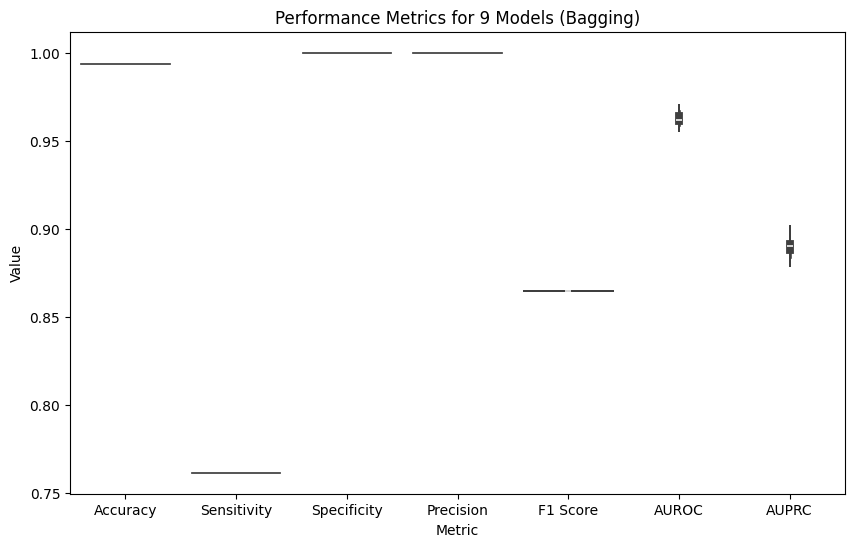

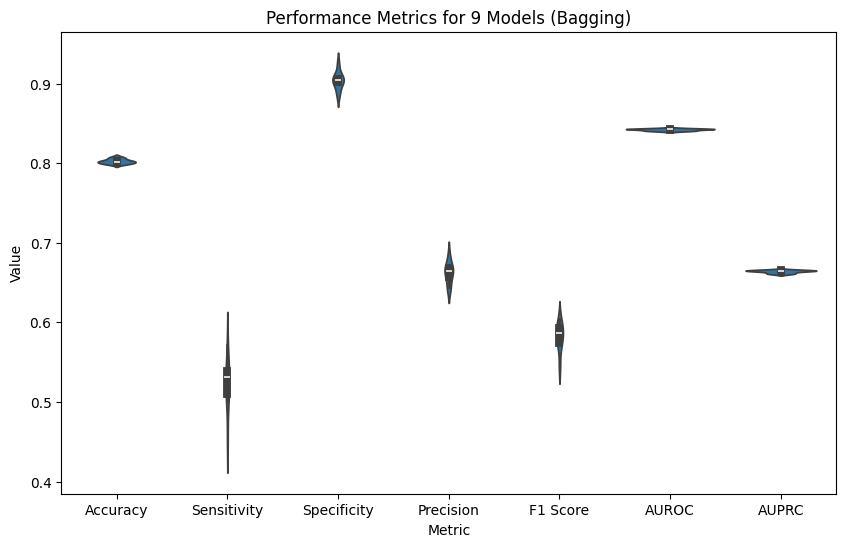

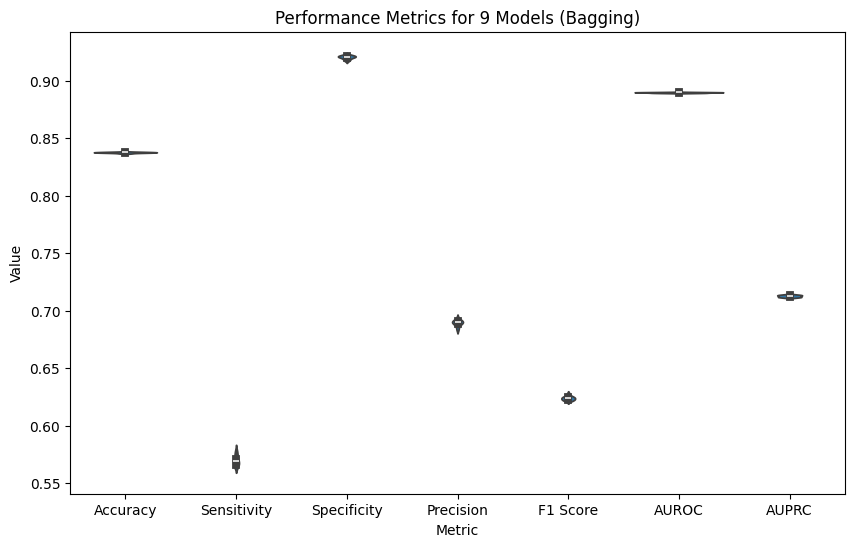

In [97]:

def test(choice):
    
    X_train, X_test, X_val, y_train, y_test, y_val = preprocess(choice)
    X_train, X_val, X_test = k_best_feature(X_train, y_train, X_val, X_test, 20, 'information_gain')
    #X_train, X_val, X_test = k_best_feature(X_train, y_train, X_val, X_test, 20, 'correlation')

    print(f'Dataset: {choice}')

    model = LogisticRegression()
    model.fit(X_train, y_train)
    accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc = model.evaluate(X_test, y_test)
    print(f'Accuracy: {accuracy}')
    print(f'Sensitivity: {sensitivity}')
    print(f'Specificity: {specificity}')
    print(f'Precision: {precision}')
    print(f'F1-score: {f1_score}')
    print(f'AUROC: {auroc}')
    print(f'AUPRC: {auprc}')

    model = Bagging(LogisticRegression, n_estimators=9)
    model.fit(X_train, y_train)
    accuracy_mean, accuracy_std, sensitivity_mean, sensitivity_std, specificity_mean, specificity_std, precision_mean, precision_std, f1_mean, f1_std, auroc, auroc_std, auprc, auprc_std = model.evaluate(X_test, y_test)
    print(f"Accuracy: {accuracy_mean:.8f} ± {accuracy_std:.8f}")
    print(f"Sensitivity: {sensitivity_mean:.8f} ± {sensitivity_std:.8f}")
    print(f"Specificity: {specificity_mean:.8f} ± {specificity_std:.8f}")
    print(f"Precision: {precision_mean:.8f} ± {precision_std:.8f}")
    print(f"F1 Score: {f1_mean:.8f} ± {f1_std:.8f}")
    print(f"AUROC: {auroc:.8f} ± {auroc_std:.8f}")
    print(f"AUPRC: {auprc:.8f} ± {auprc_std:.8f}")
    print()

    # accuracy array for all the models
    metrics = []
    labels = []
    for i, modl in enumerate(model.models):
        accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc = modl.evaluate(X_test, y_test)
        metrics.append([accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc])
        labels.append(f'Model {i + 1}')

    models = model.get_models()
    stacking = Stacking(LogisticRegression, LogisticRegression, n_estimators=9, models=models)
    stacking.fit(X_train, y_train, X_val, y_val)
    accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc = stacking.evaluate(X_test, y_test)
    print(f'Accuracy: {accuracy:.8f}')
    print(f'Sensitivity: {sensitivity:.8f}')
    print(f'Specificity: {specificity:.8f}')
    print(f'Precision: {precision:.8f}')
    print(f'F1-score: {f1_score:.8f}')
    print(f'AUROC: {auroc:.8f}')
    print(f'AUPRC: {auprc:.8f}')
    print()

    voting = VotingClassifier(LogisticRegression, n_estimators=9, models=models)
    voting.fit(X_train, y_train)
    accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc = voting.evaluate(X_test, y_test)
    print(f'Accuracy: {accuracy:.8f}')
    print(f'Sensitivity: {sensitivity:.8f}')
    print(f'Specificity: {specificity:.8f}')
    print(f'Precision: {precision:.8f}')
    print(f'F1-score: {f1_score:.8f}')
    print(f'AUROC: {auroc:.8f}')
    print(f'AUPRC: {auprc:.8f}')

    print('---------------------------------')

    return metrics, labels

metrics_credit_card , labels_credit_card = test('credit_card')
metrics_churn , labels_churn = test('churn')
metrics_adult , labels_adult = test('adult')

def func(metrics, labels):
    
    accuracy = [metric[0] for metric in metrics]
    sensitivity = [metric[1] for metric in metrics]
    specificity = [metric[2] for metric in metrics]
    precision = [metric[3] for metric in metrics]
    f1_score = [metric[4] for metric in metrics]
    auroc = [metric[5] for metric in metrics]
    auprc = [metric[6] for metric in metrics]

    # Create a DataFrame to store all metrics
    data = {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1 Score': f1_score,
        'AUROC': auroc,
        'AUPRC': auprc,
    }

    df = pd.DataFrame(data)

    # Convert the DataFrame to long format for easier plotting with Seaborn
    df_long = df.melt(var_name='Metric', value_name='Value')

    # Create a violin plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Metric', y='Value', data=df_long)

    # Add titles and labels
    plt.title('Performance Metrics for 9 Models (Bagging)')
    plt.ylabel('Value')
    plt.xlabel('Metric')

    # Show the plot
    plt.show()


func(metrics_credit_card, labels_credit_card)
func(metrics_churn, labels_churn)
func(metrics_adult, labels_adult)


